# Using Google AI's Vision Transformer for image classification of embryos

**NOTE** Currently this notebook runs with MlpMixer on GPUs and TPUs, but Vision
Transformers only run on GPUs. This is due to a temporary regression in the TPU
Node setup that is used for Colab and will be fixed soon.

See code at https://github.com/google-research/vision_transformer/

See papers at

- Vision Transformer: https://arxiv.org/abs/2010.11929
- MLP-Mixer: https://arxiv.org/abs/2105.01601
- How to train your ViT: https://arxiv.org/abs/2106.10270
- When Vision Transformers Outperform ResNets without Pretraining or Strong Data Augmentations: https://arxiv.org/abs/2106.01548

This Colab allows you to run the [JAX](https://jax.readthedocs.org) implementation of the Vision Transformer.

If you just want to load a pre-trained checkpoint from a large repository and
directly use it for inference, you probably want to go the other Colab

https://colab.sandbox.google.com/github/google-research/vision_transformer/blob/linen/vit_jax_augreg.ipynb

##### Copyright 2021 Google LLC.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/google-research/vision_transformer/blob/master/vit_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup

Needs to be executed once in every VM.

The cell below downloads the code from Github and install necessary dependencies.

In [2]:
#@markdown Select whether you would like to store data in your personal drive.
#@markdown
#@markdown If you select **yes**, you will need to authorize Colab to access
#@markdown your personal drive
#@markdown
#@markdown If you select **no**, then any changes you make will diappear when
#@markdown this Colab's VM restarts after some time of inactivity...
use_gdrive = 'no'  #@param ["yes", "no"]

if use_gdrive == 'yes':
  from google.colab import drive
  drive.mount('/gdrive')
  root = '/gdrive/My Drive/vision_transformer_colab'
  import os
  if not os.path.isdir(root):
    os.mkdir(root)
  os.chdir(root)
  print(f'\nChanged CWD to "{root}"')
else:
  from IPython import display
  display.display(display.HTML(
      '<h1 style="color:red">CHANGES NOT PERSISTED</h1>'))

In [3]:
# Clone repository and pull latest changes.
![ -d vision_transformer ] || git clone --depth=1 https://github.com/google-research/vision_transformer
!cd vision_transformer && git pull

Already up to date.


In [4]:
!pip install -qr vision_transformer/vit_jax/requirements.txt

### Imports

In [5]:
# Shows all available pre-trained models.
!gsutil ls -lh gs://vit_models/imagenet*
!gsutil ls -lh gs://vit_models/sam
!gsutil ls -lh gs://mixer_models/*

gs://vit_models/imagenet21k+imagenet2012/:
377.57 MiB  2020-11-30T16:17:02Z  gs://vit_models/imagenet21k+imagenet2012/R50+ViT-B_16.npz
330.29 MiB  2020-10-29T17:05:52Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_16-224.npz
 331.4 MiB  2020-10-20T11:48:22Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_16.npz
336.89 MiB  2020-10-20T11:47:36Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_32.npz
334.78 MiB  2021-03-12T09:04:16Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_8.npz
  1.13 GiB  2020-10-29T17:08:31Z  gs://vit_models/imagenet21k+imagenet2012/ViT-L_16-224.npz
  1.14 GiB  2020-10-20T11:53:44Z  gs://vit_models/imagenet21k+imagenet2012/ViT-L_16.npz
  1.14 GiB  2020-10-20T11:50:56Z  gs://vit_models/imagenet21k+imagenet2012/ViT-L_32.npz

gs://vit_models/imagenet21k/:
450.23 MiB  2021-01-20T14:12:43Z  gs://vit_models/imagenet21k/R26+ViT-B_32.npz
439.85 MiB  2020-11-30T10:10:15Z  gs://vit_models/imagenet21k/R50+ViT-B_16.npz
  1.31 GiB  2021-01-20T14:11:54Z  gs://vit_models/ima

In [6]:
# Download a pre-trained model.

# Note: you can really choose any of the above, but this Colab has been tested
# with the models of below selection...
model_name = 'ViT-B_32'  #@param ["ViT-B_32", "Mixer-B_16"]

if model_name.startswith('ViT'):
  ![ -e "$model_name".npz ] || gsutil cp gs://vit_models/imagenet21k/"$model_name".npz .
if model_name.startswith('Mixer'):
  ![ -e "$model_name".npz ] || gsutil cp gs://mixer_models/imagenet21k/"$model_name".npz .

import os
assert os.path.exists(f'{model_name}.npz')

In [7]:
# Google Colab "TPU" runtimes are configured in "2VM mode", meaning that JAX
# cannot see the TPUs because they're not directly attached. Instead we need to
# setup JAX to communicate with a second machine that has the TPUs attached.
import os
if 'google.colab' in str(get_ipython()) and 'COLAB_TPU_ADDR' in os.environ:
  import jax
  import jax.tools.colab_tpu
  jax.tools.colab_tpu.setup_tpu()
  print('Connected to TPU.')
else:
  print('No TPU detected. Can be changed under "Runtime/Change runtime type".')

Connected to TPU.


In [32]:
from absl import logging
import flax
import jax
from matplotlib import pyplot as plt
import numpy as np
import tqdm

logging.set_verbosity(logging.INFO)

# Shows the number of available devices.
# In a CPU/GPU runtime this will be a single device.
# In a TPU runtime this will be 8 cores.
jax.local_devices()

[autoreload of vit_jax.input_pipeline failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
  File "./vision_transformer/vit_jax/input_pipeline.py", line 215
    im = tf.image.resize(im, [image_size, image_size])
     ^
IndentationError: expected an indented block
]


[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

In [33]:
%pwd

'/content'

In [44]:
# Open some code files in a split editor on the right.
# You can open more files in the file tab on the left.
from google.colab import files
files.view('vision_transformer/vit_jax/configs/common.py')
files.view('vision_transformer/vit_jax/configs/models.py')
files.view('vision_transformer/vit_jax/checkpoint.py')
files.view('vision_transformer/vit_jax/input_pipeline.py')
files.view('vision_transformer/vit_jax/models.py')
files.view('vision_transformer/vit_jax/momentum_clip.py')
files.view('vision_transformer/vit_jax/train.py')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Change line 133 from input_pipeline.py to deal with null pp.crop
### also might want to modify train.py 

In [58]:
# Import files from repository.
# Updating the files in the editor on the right will immediately update the
# modules by re-importing them.

import sys
if './vision_transformer' not in sys.path:
  sys.path.append('./vision_transformer')

%load_ext autoreload
%autoreload 2

from vit_jax import checkpoint
from vit_jax import input_pipeline
from vit_jax import utils
from vit_jax import models
from vit_jax import momentum_clip
from vit_jax import train
from vit_jax.configs import common as common_config
from vit_jax.configs import models as models_config

In [81]:
# Helper functions for images.

# labelnames = dict(
#   # https://www.cs.toronto.edu/~kriz/cifar.html
#   cifar10=('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'),
#   # https://www.cs.toronto.edu/~kriz/cifar.html
#   cifar100=('apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm')
# )
labelnames = dict(
    compressed_embryos=('onset', 'not_onset')
 )
def make_label_getter(dataset):
  """Returns a function converting label indices to names."""
  def getter(label):
    if dataset in labelnames:
      return labelnames[dataset][label]
    return f'label={label}'
  return getter

def show_img(img, ax=None, title=None):
  """Shows a single image."""
  if ax is None:
    ax = plt.gca()
  ax.imshow(img[...])
  ax.set_xticks([])
  ax.set_yticks([])
  if title:
    ax.set_title(title)

def show_img_grid(imgs, titles):
  """Shows a grid of images."""
  n = int(np.ceil(len(imgs)**.5))
  _, axs = plt.subplots(n, n, figsize=(3 * n, 3 * n))
  for i, (img, title) in enumerate(zip(imgs, titles)):
    img = (img + 1) / 2  # Denormalize
    show_img(img, axs[i // n][i % n], title)

### Load dataset

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
from pathlib import Path
root_directory = Path("/content/")
drive_path = root_directory / 'drive' / 'MyDrive' / 'CS101' 

In [15]:
%pwd

'/content'

In [16]:
%ls /content/drive/MyDrive/CS101/classification

checkpoints/           embryo_compdata2.zip  input_pipeline.py
embryo_classification  embryo_compdata.zip   transformer.ipynb


In [17]:
# Path to zip file in my drive
!unzip '/drive/My Drive/CS101/classification/embryo_compdata.zip'

unzip:  cannot find or open /drive/My Drive/CS101/classification/embryo_compdata.zip, /drive/My Drive/CS101/classification/embryo_compdata.zip.zip or /drive/My Drive/CS101/classification/embryo_compdata.zip.ZIP.


### this zip has the images contained in the format required by the model

In [18]:
!unzip '/content/drive/My Drive/CS101/classification/embryo_compdata2.zip'

Archive:  /content/drive/My Drive/CS101/classification/embryo_compdata2.zip
replace __MACOSX/._embryo_compdata2? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [19]:
#path = drive_path / 'classification' / 'CS101_data' / 'embryo-89-8cell-DIC_AIF_DTCWT-onset'
data_path = root_directory / 'embryo_compdata2'
train_path = os.path.join(data_path, 'train')
test_path = os.path.join(data_path, 'test')

In [20]:
train_path

'/content/embryo_compdata2/train'

### Set hyperparameters

In [59]:
#dataset = 'cifar10'
#config = common_config.with_dataset(common_config.get_config(), dataset)

dataset = 'compressed_embryos'
config = common_config.get_config()
batch_size = 128 # use 16 * 8 = 128 with 8 TPUs to use each with batch size 16
num_classes = 2

config.dataset = ''
config.tfds_manual_dir = data_path
config.batch = batch_size
config.batch_eval = batch_size
#config.pp.crop = 512

In [27]:
config.batch

128

In [50]:
input_pipeline.get_directory_info(train_path)

{'examples_glob': '/content/embryo_compdata2/train/*/*.jpg',
 'int2str': <function vit_jax.input_pipeline.get_directory_info.<locals>.<lambda>>,
 'num_classes': 2,
 'num_examples': 2044}

In [60]:
# For details about setting up datasets, see input_pipeline.py on the right.
# ds_train = input_pipeline.get_data_from_tfds(config=config, mode='train')
# ds_test = input_pipeline.get_data_from_tfds(config=config, mode='test')
ds_train = input_pipeline.get_data_from_directory(config=config, directory=train_path, mode='train')
ds_test = input_pipeline.get_data_from_directory(config=config, directory=test_path, mode='test')

del config  # Only needed to instantiate datasets.

In [52]:
type(ds_train)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [89]:
# Fetch a batch of test images for illustration purposes.
batch = next(iter(ds_test.as_numpy_iterator()))
# Note the shape : [num_local_devices, local_batch_size, h, w, c]
batch['image'].shape

(8, 16, 512, 512, 3)

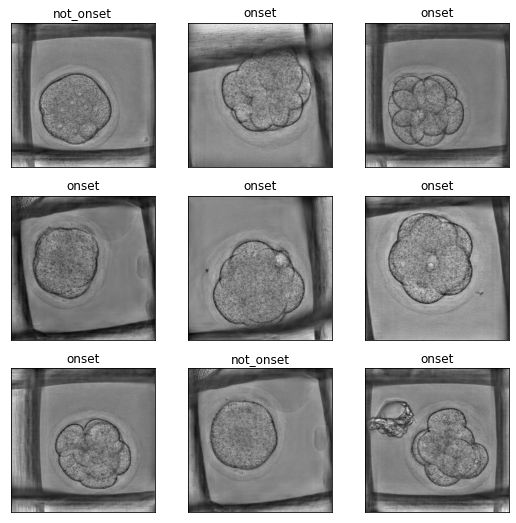

In [90]:
# Show some imags with their labels.
images, labels = batch['image'][0][:9], batch['label'][0][:9]
titles = map(make_label_getter(dataset), labels.argmax(axis=1))
show_img_grid(images, titles)

### need to remove if-statement starting on line 199 in input_pipeline.py in order to remove cropping in train set

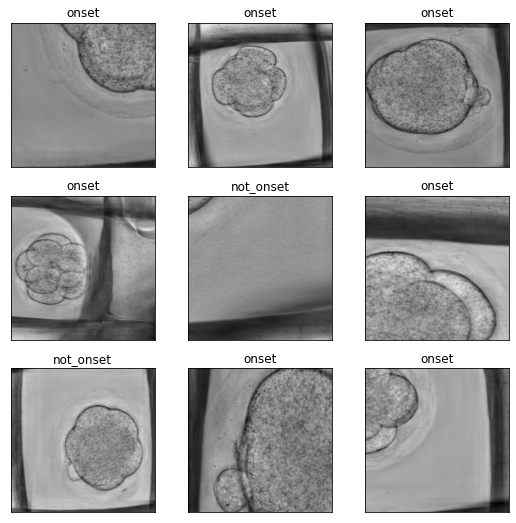

In [91]:
# Same as above, but with train images.
# Note how images are cropped/scaled differently.
# Check out input_pipeline.get_data() in the editor at your right to see how the
# images are preprocessed differently.
batch = next(iter(ds_train.as_numpy_iterator()))
images, labels = batch['image'][0][:9], batch['label'][0][:9]
titles = map(make_label_getter(dataset), labels.argmax(axis=1))
show_img_grid(images, titles)

### Load pre-trained

In [56]:
model_config = models_config.MODEL_CONFIGS[model_name]
model_config

classifier: token
hidden_size: 768
name: ViT-B_32
patches:
  size: !!python/tuple
  - 32
  - 32
representation_size: null
transformer:
  attention_dropout_rate: 0.0
  dropout_rate: 0.0
  mlp_dim: 3072
  num_heads: 12
  num_layers: 12

In [64]:
# Load model definition & initialize random parameters.
# This also compiles the model to XLA (takes some minutes the first time).
if model_name.startswith('Mixer'):
  model = models.MlpMixer(num_classes=num_classes, **model_config)
else:
  model = models.VisionTransformer(num_classes=num_classes, **model_config)
variables = jax.jit(lambda: model.init(
    jax.random.PRNGKey(0),
    # Discard the "num_local_devices" dimension of the batch for initialization.
    batch['image'][0, :1],
    train=False,
), backend='cpu')()

In [65]:
# Load and convert pretrained checkpoint.
# This involves loading the actual pre-trained model results, but then also also
# modifying the parameters a bit, e.g. changing the final layers, and resizing
# the positional embeddings.
# For details, refer to the code and to the methods of the paper.
params = checkpoint.load_pretrained(
    pretrained_path=f'{model_name}.npz',
    init_params=variables['params'],
    model_config=model_config,
)

INFO:absl:Inspect extra keys:
{'pre_logits/kernel', 'pre_logits/bias'}
INFO:absl:load_pretrained: drop-head variant
INFO:absl:load_pretrained: resized variant: (1, 50, 768) to (1, 257, 768)
INFO:absl:load_pretrained: grid-size from 7 to 16


### Evaluate

In [66]:
# So far, all our data is in the host memory. Let's now replicate the arrays
# into the devices.
# This will make every array in the pytree params become a ShardedDeviceArray
# that has the same data replicated across all local devices.
# For TPU it replicates the params in every core.
# For a single GPU this simply moves the data onto the device.
# For CPU it simply creates a copy.
params_repl = flax.jax_utils.replicate(params)
print('params.cls:', type(params['head']['bias']).__name__,
      params['head']['bias'].shape)
print('params_repl.cls:', type(params_repl['head']['bias']).__name__,
      params_repl['head']['bias'].shape)

params.cls: DeviceArray (2,)
params_repl.cls: _ShardedDeviceArray (8, 2)


In [67]:
# Then map the call to our model's forward pass onto all available devices.
vit_apply_repl = jax.pmap(lambda params, inputs: model.apply(
    dict(params=params), inputs, train=False))

In [68]:
def get_accuracy(params_repl):
  """Returns accuracy evaluated on the test set."""
  good = total = onset_preds = not_onset_preds = 0
  # steps = input_pipeline.get_dataset_info(dataset, 'test')['num_examples'] // batch_size
  steps = input_pipeline.get_directory_info(test_path)['num_examples'] // batch_size
  print('num_examples:', input_pipeline.get_directory_info(test_path)['num_examples'])

  for _, batch in zip(tqdm.trange(steps), ds_test.as_numpy_iterator()):
    predicted = vit_apply_repl(params_repl, batch['image'])
    #print('predicted:', predicted)
    print('argmax:', predicted.argmax(axis=-1))
    print('label:', batch['label'].argmax(axis=-1))
    is_same = predicted.argmax(axis=-1) == batch['label'].argmax(axis=-1)
    #print(np.shape(is_same), is_same)
    is_onset = predicted.argmax(axis=-1) == 1
    not_onset = predicted.argmax(axis=-1) == 0
    print('num same:', is_same.sum())
    good += is_same.sum()
    onset_preds += is_onset.sum()
    not_onset_preds += not_onset.sum()

    total += len(is_same.flatten())
  print('good:', good)
  print('onset/not onset predictions')
  print(onset_preds, not_onset_preds)
  return good / total

In [69]:
# Random performance without fine-tuning.
get_accuracy(params_repl)

num_examples: 428


 33%|███▎      | 1/3 [00:21<00:42, 21.47s/it]

argmax: [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
label: [[1 0 0 0 1 0 0 1 1 0 0 0 1 0 0 0]
 [0 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0]
 [0 1 0 1 0 1 1 1 0 0 0 0 0 0 1 1]
 [0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 1 1 1 0 0 1 1 1 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [1 1 0 0 1 0 1 1 0 0 1 0 0 0 0 0]
 [0 1 0 0 1 1 1 1 0 0 1 1 0 1 0 0]]
num same: 87


 67%|██████▋   | 2/3 [00:25<00:11, 11.07s/it]

argmax: [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
label: [[0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 1]
 [1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0]
 [1 1 1 0 1 0 0 1 1 0 1 1 0 0 1 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1]
 [0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0]
 [0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0]
 [1 0 0 0 1 1 0 1 0 1 0 1 0 1 0 1]]
num same: 89


100%|██████████| 3/3 [00:29<00:00,  9.71s/it]

argmax: [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
label: [[1 1 0 0 0 0 1 0 0 0 1 1 0 0 0 1]
 [0 1 0 0 0 1 0 0 0 1 0 1 1 0 1 0]
 [0 0 0 1 1 1 1 0 1 0 0 0 0 0 1 0]
 [0 1 0 0 1 0 1 0 0 0 0 1 1 0 0 0]
 [0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 1]
 [0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 1]
 [0 0 0 0 0 1 1 1 1 0 1 0 0 0 1 1]
 [1 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0]]
num same: 83
good: 259
onset/not onset predictions
0 384


DeviceArray(0.6744792, dtype=float32)

#### We note that the accuracy before training is equal to proportion of pre-onset images the since the model predicts all 0s at this point

### Fine-tune

In [70]:
# 100 Steps take approximately 15 minutes in the TPU runtime.
total_steps = 500
warmup_steps = 5
decay_type = 'cosine'
grad_norm_clip = 1
# This controls in how many forward passes the batch is split. 8 works well with
# a TPU runtime that has 8 devices. 64 should work on a GPU. You can of course
# also adjust the batch_size above, but that would require you to adjust the
# learning rate accordingly.
accum_steps = 8
base_lr = 0.01

In [71]:
# Check out train.make_update_fn in the editor on the right side for details.
lr_fn = utils.create_learning_rate_schedule(total_steps, base_lr, decay_type, warmup_steps)
update_fn_repl = train.make_update_fn(
    apply_fn=model.apply, accum_steps=accum_steps, lr_fn=lr_fn)
# We use a momentum optimizer that uses half precision for state to save
# memory. It als implements the gradient clipping.
opt = momentum_clip.Optimizer(grad_norm_clip=grad_norm_clip).create(params)
opt_repl = flax.jax_utils.replicate(opt)

In [72]:
# Initialize PRNGs for dropout.
update_rng_repl = flax.jax_utils.replicate(jax.random.PRNGKey(0))

# Train Attempts
### ViT-B_32 on TPU (technically supposed to run on GPU), learning rate = 0.03
pretrained without fine tuning: 0.6744792 NOTE: predicting all no  \
100 steps: 0.71875, 0.7291667  \
500 steps: 0.6979167  \
1000 steps: 0.7057292  \
#### learning rate = 0.01
100 steps: 0.7421875  \ 
500 steps: 0.7447917  \
1000 steps: 0.7161459  \
### learning rate = 0.01 on non-cropped training set
100 steps: 0.671875 \ 
500 steps: 0.6640625  \
#### ViT-B_32 on GPU, learning rate = 0.03
pretrained without fine tuning: 0.68269235 NOTE: predicting all no  \
100 steps: 0.68269235 \
500 steps: 0.6754808  \
1000 steps: 0.

100%|██████████| 500/500 [36:15<00:00,  4.35s/it]


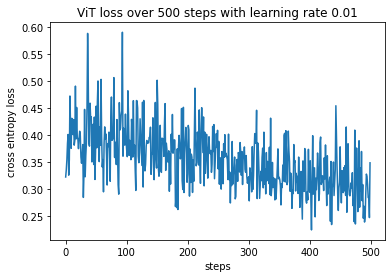

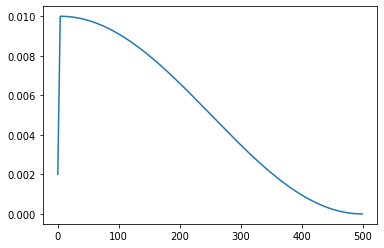

In [74]:
losses = []
lrs = []
# Completes in ~20 min on the TPU runtime.
for step, batch in zip(
    tqdm.trange(1, total_steps + 1),
    ds_train.as_numpy_iterator(),
):

  opt_repl, loss_repl, update_rng_repl = update_fn_repl(
      opt_repl, flax.jax_utils.replicate(step), batch, update_rng_repl)
  losses.append(loss_repl[0])
  lrs.append(lr_fn(step))

plt.plot(losses)
plt.title('ViT loss over ' + str(total_steps) + ' steps with learning rate ' + str(base_lr))
plt.xlabel('steps')
plt.ylabel('cross entropy loss')
plt.figure()
plt.plot(lrs)

In [79]:
# Should be ~96.7% for Mixer-B/16 or 97.7% for ViT-B/32 on CIFAR10 (both @224)
get_accuracy(opt_repl.target)

num_examples: 428


 33%|███▎      | 1/3 [00:04<00:09,  4.80s/it]

argmax: [[0 1 0 1 1 0 1 0 1 0 0 0 0 1 0 1]
 [1 1 1 1 1 0 0 1 1 0 1 0 0 1 1 1]
 [0 0 0 0 0 1 1 0 1 1 1 0 0 0 1 1]
 [1 0 0 1 1 0 0 0 0 0 1 1 0 0 0 1]
 [1 0 1 0 0 0 1 1 1 0 1 0 1 1 0 1]
 [0 0 1 1 0 1 1 0 1 1 0 0 1 0 0 1]
 [0 1 0 0 0 0 1 0 1 0 1 0 0 0 0 0]
 [0 1 0 0 0 1 0 0 1 0 0 0 0 1 1 0]]
label: [[0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0]
 [1 1 0 1 1 0 0 0 0 1 1 0 0 0 1 1]
 [0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1]
 [1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1]
 [1 0 1 0 0 0 1 1 0 0 0 0 1 1 0 0]
 [1 0 0 0 0 1 1 0 0 1 0 0 0 0 0 1]
 [0 1 0 1 0 1 1 1 1 0 1 0 0 0 0 0]
 [0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 1]]
num same: 96


 67%|██████▋   | 2/3 [00:08<00:04,  4.26s/it]

argmax: [[0 0 0 0 1 0 1 1 0 1 0 1 0 1 1 0]
 [0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1]
 [0 0 1 1 0 1 1 1 1 0 0 1 1 1 0 0]
 [1 1 0 0 0 0 0 1 1 0 1 0 1 0 0 0]
 [0 0 1 0 1 1 0 1 0 1 0 0 0 0 0 0]
 [1 0 1 1 0 0 1 1 0 0 0 1 0 0 1 1]
 [1 1 0 0 1 1 1 1 0 1 0 0 0 0 1 1]
 [1 0 0 1 1 0 1 0 0 0 0 1 1 1 0 0]]
label: [[0 0 0 0 1 0 1 1 0 1 0 0 1 1 0 0]
 [0 0 0 0 1 0 0 0 0 1 1 0 0 1 0 0]
 [0 0 1 0 0 0 1 1 0 1 0 0 1 1 0 1]
 [0 1 0 0 0 1 0 1 1 0 1 0 1 0 1 0]
 [0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0]
 [1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 1]
 [0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1]
 [1 0 0 1 0 0 1 0 0 1 0 1 0 1 0 0]]
num same: 93


100%|██████████| 3/3 [00:12<00:00,  4.17s/it]

argmax: [[1 0 1 1 0 1 1 0 0 1 1 1 1 1 1 0]
 [0 1 0 1 1 1 1 0 0 0 0 0 0 1 1 0]
 [1 0 0 0 0 1 1 0 1 1 0 1 0 1 1 1]
 [0 1 0 0 0 0 1 1 0 1 1 0 0 0 1 1]
 [1 0 0 0 1 1 0 1 0 0 1 1 1 1 1 1]
 [0 0 1 1 1 0 1 1 1 1 1 0 0 1 0 1]
 [0 1 0 0 0 1 0 1 0 0 0 0 1 0 1 0]
 [0 1 1 0 1 0 0 0 1 1 0 0 1 0 1 0]]
label: [[0 0 0 0 0 1 1 0 1 0 0 1 1 1 1 0]
 [0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0]
 [0 1 0 1 0 0 0 0 1 1 0 1 0 1 0 1]
 [0 1 0 0 0 0 0 1 0 1 0 0 0 1 1 0]
 [1 0 0 0 1 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1]
 [0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0]
 [0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 1]]
num same: 88
good: 277
onset/not onset predictions
181 203


DeviceArray(0.7213542, dtype=float32)

## Code below not used for embryo classification

### Inference

In [ ]:
# Download a pre-trained model.

if model_name.startswith('Mixer'):
  # Download model trained on imagenet2012
  ![ -e "$model_name"_imagenet2012.npz ] || gsutil cp gs://mixer_models/imagenet1k/"$model_name".npz "$model_name"_imagenet2012.npz
  model = models.MlpMixer(num_classes=1000, **model_config)
else:
  # Download model pre-trained on imagenet21k and fine-tuned on imagenet2012.
  ![ -e "$model_name"_imagenet2012.npz ] || gsutil cp gs://vit_models/imagenet21k+imagenet2012/"$model_name".npz "$model_name"_imagenet2012.npz
  model = models.VisionTransformer(num_classes=1000, **model_config)

import os
assert os.path.exists(f'{model_name}_imagenet2012.npz')

In [98]:
# Load and convert pretrained checkpoint.
params = checkpoint.load(f'{model_name}_imagenet2012.npz')
params['pre_logits'] = {}  # Need to restore empty leaf for Flax.

In [99]:
# Get imagenet labels.
!wget https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
imagenet_labels = dict(enumerate(open('ilsvrc2012_wordnet_lemmas.txt')))

--2021-12-02 10:40:38--  https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.193.128, 173.194.195.128, 173.194.196.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21675 (21K) [text/plain]
Saving to: ‘ilsvrc2012_wordnet_lemmas.txt’

ilsvrc2012_wordnet_ 100%[===================>]  21.17K  --.-KB/s    in 0s      

2021-12-02 10:40:38 (73.6 MB/s) - ‘ilsvrc2012_wordnet_lemmas.txt’ saved [21675/21675]



--2021-12-02 10:40:39--  https://picsum.photos/384
Resolving picsum.photos (picsum.photos)... 104.26.5.30, 172.67.74.163, 104.26.4.30, ...
Connecting to picsum.photos (picsum.photos)|104.26.5.30|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://i.picsum.photos/id/868/384/384.jpg?hmac=o3iVZ0ShhLv7Y30RQU8joFVpaLpQZiurtI1Z87NkRZM [following]
--2021-12-02 10:40:39--  https://i.picsum.photos/id/868/384/384.jpg?hmac=o3iVZ0ShhLv7Y30RQU8joFVpaLpQZiurtI1Z87NkRZM
Resolving i.picsum.photos (i.picsum.photos)... 104.26.5.30, 104.26.4.30, 172.67.74.163, ...
Connecting to i.picsum.photos (i.picsum.photos)|104.26.5.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘picsum.jpg’

picsum.jpg              [ <=>                ]  23.75K  --.-KB/s    in 0.001s  

2021-12-02 10:40:39 (40.8 MB/s) - ‘picsum.jpg’ saved [24324]



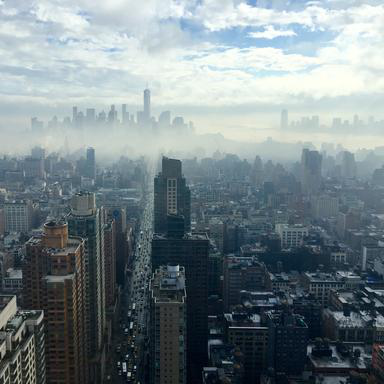

In [100]:
# Get a random picture with the correct dimensions.
resolution = 224 if model_name.startswith('Mixer') else 384
!wget https://picsum.photos/$resolution -O picsum.jpg
import PIL
img = PIL.Image.open('picsum.jpg')
img

In [101]:
# Predict on a batch with a single item (note very efficient TPU usage...)
logits, = model.apply(dict(params=params), (np.array(img) / 128 - 1)[None, ...], train=False)

In [102]:
preds = flax.nn.softmax(logits)
for idx in preds.argsort()[:-11:-1]:
  print(f'{preds[idx]:.5f} : {imagenet_labels[idx]}', end='')

0.23348 : airship, dirigible
0.14130 : balloon
0.06289 : bell_cote, bell_cot
0.03267 : suspension_bridge
0.02703 : seashore, coast, seacoast, sea-coast
0.02030 : traffic_light, traffic_signal, stoplight
0.02004 : lakeside, lakeshore
0.01899 : palace
0.01520 : flagpole, flagstaff
0.01519 : wing
